In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import galsim 
import corner 

from matplotlib.patches import Ellipse

In [3]:
#directories that would be using 
repo = '/Users/Ismael/code/lensing/SMFF/'
os.chdir(repo)

In [4]:
def showImage(image,ax=None,extent=None,vmin=None,vmax=None,origin='lower',cmap ='bwr'):
    
    if vmin == None: 
        vmin = -abs(image).max()
    if vmax == None: 
        vmax = abs(image).max()
    
    
    if ax is None: 
        return plt.imshow(image, cmap=cmap,vmax=vmax,vmin=vmin,interpolation='None',origin=origin, extent=extent)
    else: 
        return ax.imshow(image, cmap=cmap,vmax=vmax,vmin=vmin,interpolation='None',origin=origin,extent=extent)

In [5]:
def plot_matrix(matrix, param_names): 

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    n,_ = matrix.shape #assume square matrix
    plt.xticks(list(plt.xticks()[0]), [None] + param_names)
    plt.yticks(list(plt.yticks()[0]), [None] + param_names)
    
    plt.tick_params(labelsize=20)


    ax.matshow(matrix, cmap=plt.cm.Blues)


    for i in range(n):
        for j in range(n):
            c = matrix[j,i]
            ax.text(i, j, '{:.2g}'.format(c), va='center', ha='center',size=20)

In [6]:
latex_names =[r'$\rm{flux}$','$x_{0}$','$y_{0}$',r'$\rm{HLR}$','$\\varepsilon_{1}$','$\\varepsilon_{2}$']

In [7]:
#plotting constants
LINEWIDTH = 2
AXIS_NUMBER_SIZE = 45 
AXIS_LABEL_SIZE = 55 
AXIS_WIDTH = 3
AXIS_LENGTH = 12

FIG_SIZE = 40 

MARKER_SIZE = 14
LINE_WIDTH = 5

## Reloads 

In [8]:
from importlib import reload 

from analysis import defaults
from analysis import fisher
from analysis import galfun
import corner

reload(defaults)
reload(fisher)
reload(galfun)
reload(corner)

<module 'corner' from '/Users/Ismael/anaconda3/envs/galsim/lib/python3.6/site-packages/corner/__init__.py'>

# Triangle 

In [9]:
#parameters of galaxy to draw. 
model = 'gaussian' #possible options of model and psf_model are in documentation. 
psf_model = 'psf_gaussian'
g1 = .2
g2 = .2 
hlr = .7
psf_fwhm = .7
snr = 20.
x0 = 1. 
y0 = 1. 

#project folder name where you want to write galaxy information 
project = 'project-tutorial-fits-chi4'


#image parameters 
pixel_scale=.2 
nx = 45
ny = 45

In [10]:
number_fits = 40000 

In [11]:
g_parameters = galfun.GParameters(project) #extract parameters from file created by generate.py 
image_renderer = galfun.ImageRenderer(pixel_scale=pixel_scale,nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, snr=snr)

In [12]:
g_parameters.id_params

{'1': OrderedDict([('galaxy_model', 'gaussian'),
              ('psf_model', 'psf_gaussian'),
              ('flux', 1.0),
              ('e1', 0.37037037037037035),
              ('hlr', 0.7),
              ('e2', 0.37037037037037035),
              ('y0', 1.0),
              ('x0', 1.0),
              ('psf_flux', 1.0),
              ('psf_fwhm', 0.7)])}

In [15]:
%%capture
pulls,residuals,biases,pull_means,res_stds,pull_mins,pull_maxs,redchis = galfun.read_results(project,g_parameters,fish)


In [16]:
#constants needed for the plots below 
EXTENT_PULL = (-3, 3)
BINS_PULL = 40
SIG_DIGITS = 4

number_fits = 40000 

In [17]:
def errorEllipseCor(centroid, cor_xy, alpha=1.52):
    """
    Return a correlation ellipse according to Dan Coe paper arxiv.0906.4123.

    We use correlations instead of covariances for the ellipses because most of
    the parameters in our models have dimensions.
    Confidence level by default is 68.3% -> alpha = 1.52 according to the same
    paper.

    Args:
        centroid(:py:tuple): Position of the center of the ellipse in
                             (x,y) form.

    Returns:
        An mpatch.Ellipse object
    """
    import matplotlib.patches as mpatch

    a = 1 + cor_xy
    b = 1 - cor_xy
    theta = 45
    width = 2 * alpha * a
    height = 2 * alpha * b

    ellipse = mpatch.Ellipse(xy=centroid, width=width, height=height,
                             angle=theta, edgecolor='r', fc='None', lw=2)

    return ellipse

In [18]:
def fisher_prediction(params,bound_mins,bound_maxs,fish,number_fits):
    """Draws a triangle shaped plot with the fisher prediction for 68% confidence level"""

    fish_figure = plt.figure(figsize=(11, 11)) #this is the figure containing the fisher predictions. 
    normalized_area = (EXTENT_PULL[1] - EXTENT_PULL[0]) * (number_fits / BINS_PULL)
    param_names = fish.param_names
    num_params = len(params)
    color_hist = 'red'
    for param in params:
        # produce pull plot.

        dim = num_params + 1  # for redchi add extra dimension.
        #here we create our triangle. 
        ####i are the rows, or the y-axis, and j are the columns or the x-axis. 
        for i in range(dim):
            for j in range(dim):
                plt.rc('text', usetex=True)
                if i < num_params and j < num_params and i >= j:
                    param_i = param_names[i]
                    param_j = param_names[j]
                    sigma_i = math.sqrt(fish.covariance_matrix[param_i,param_i])
                    sigma_j = math.sqrt(fish.covariance_matrix[param_j, param_j])
                    mean = (fish.biases[param_j] / sigma_j,fish.biases[param_i] / sigma_i)
                    cor_xy = fish.correlation_matrix[param_j, param_i]

                    if i == j:
                        sigma_gauss = 1 #normalize normal pdf.
                        x = np.linspace(EXTENT_PULL[0], EXTENT_PULL[1], 1000)
                        ax = fish_figure.add_subplot(dim, dim, dim * i + j + 1)
                        ax.plot(x, normalized_area * mlab.normpdf(x, mean[0],sigma_gauss),color=color_hist)
                        sigma_fisher = round(sigma_i, SIG_DIGITS)
                        sigma_fits = round(res_stds[param_i], SIG_DIGITS)

                        #error of bias_fits
                        sigma_1 = round(sigma_fits / math.sqrt(number_fits),SIG_DIGITS)
                        #error of sigma_fits
                        sigma_2 = round(sigma_fits / math.sqrt(2*number_fits), SIG_DIGITS)
                        bias_fisher = round(fish.biases[param_i],SIG_DIGITS)
                        bias_fits = round(biases[param_i],SIG_DIGITS)
                        
                        if i == 4 or i==5: 
                            data = (
                                  r'\begin{eqnarray*}' +
                                  r'\sigma_{\rm F}' + '&=&' +
                                  '{:+.4f}'.format(sigma_fisher) +
                                  r'\\' +
                                  r'\sigma_{\rm fit}' + '&=&' +
                                  '{:+.4f}'.format(sigma_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_2) +
                                  r'\\' +
                                  r'b_{F}' + '&=&' +
                                  '{:+.4f}'.format(bias_fisher) +
                                  r'\\' +
                                  r'b_{\rm fit}' + '&=&' +
                                  '{:+.4f}'.format(bias_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_1) +
                                  r'\end{eqnarray*}')
                        
                        else: 
                            data = (
                                  r'\begin{eqnarray*}' +
                                  r'\sigma_{\rm F}' + '&=&' +
                                  '{:.4f}'.format(sigma_fisher) +
                                  r'\\' +
                                  r'\sigma_{\rm fit}' + '&=&' +
                                  '{:.4f}'.format(sigma_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_2) +
                                  r'\\' +
                                  r'b_{F}' + '&=&' +
                                  '{:+.4f}'.format(bias_fisher) +
                                  r'\\' +
                                  r'b_{\rm fit}' + '&=&' +
                                  '{:+.4f}'.format(bias_fits) +
                                  r'\pm' +
                                  '{:.4f}'.format(sigma_1) +
                                  r'\end{eqnarray*}')




                        ax.text(1.725, .35, data,
                                transform=ax.transAxes, ha='center',
                                fontsize=10,
                                fontweight='bold')

                        # add green lines indicating bounds.
                        ax.axvline(x=pull_mins[param_j], color='g')
                        ax.axvline(x=pull_maxs[param_j], color='g')

                    elif i > j:
                        # draw an error_ellipse in off-diagonals axises.
                        ellip = errorEllipseCor(mean, cor_xy)
                        ax = fish_figure.add_subplot(dim, dim,
                                                     dim * i + j + 1)
                        ax.add_patch(ellip)

                        ax.axhline(y=pull_mins[param_i], color='g')
                        ax.axhline(y=pull_maxs[param_i], color='g')
#                         ax.axhline(y=mean[1], color='y')


                        ax.axvline(x=pull_mins[param_j], color='g')
                        ax.axvline(x=pull_maxs[param_j], color='g')
#                         ax.axvline(x=mean[0], color='y')

                else:
                    ax = fish_figure.add_subplot(dim,
                                                 dim,
                                                 dim * i + j + 1)
    plt.rc('text', usetex=True)
    return fish_figure

/Users/Ismael/anaconda3/envs/galsim/lib/python3.6/site-packages/ipykernel/__main__.py:30: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/Users/Ismael/anaconda3/envs/galsim/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


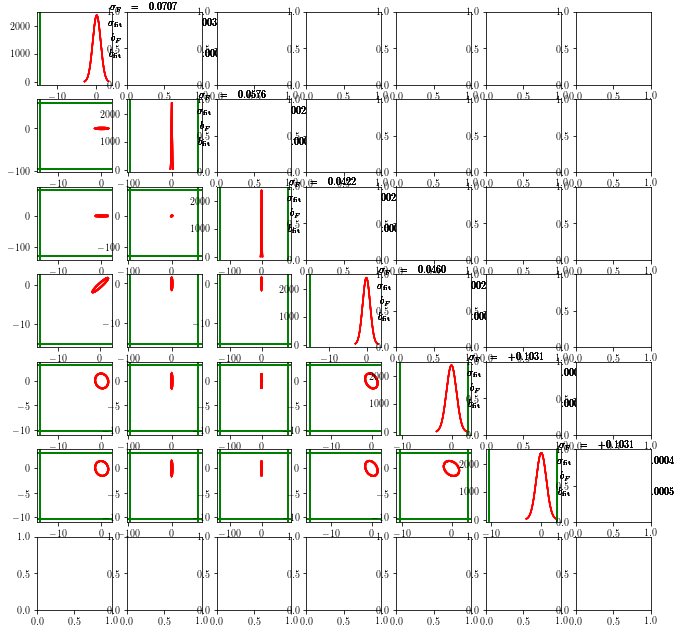

In [19]:
fish_figure = fisher_prediction(pulls.keys(),pull_mins,pull_maxs,fish,number_fits)

### Produce final corner plot 

In [23]:
def fit_plots(pulls,pull_mins,pull_maxs,pull_means,redchis,fish,fish_figure=None):
    """Draws a triangle plot with fisher predictions overalayed and the results from the fittings."""
    param_names = fish.param_names
    num_params = fish.num_params

    # have to transform point.values to a convenient form for the plot.
    extents = [EXTENT_PULL] * num_params + [(min(redchis),max(redchis))]
    points_plot = []
    truths = []
    plot_names = []

    for param in param_names:
        if 'e1' in param:
            tex_param = '$\\chi_{1}$'
        elif 'e2' in param:
            tex_param = '$\\chi_{2}$'
        elif 'x0' in param:
            tex_param = r'$x_{0}$'
        elif 'y0' in param:
            tex_param = r'$y_{0}$'
        elif 'hlr' in param: 
            tex_param = r'$\rm{HLR}$'
        else:
            tex_param = r'$\rm{flux}$'
        plot_names.append(tex_param)

    plot_names.append(r'$\chi^{2}/dof$')

    for param in param_names:
        points_plot.append(pulls[param])
        truths.append(pull_means[param])

    #chi2, redchi should be centered around 1
    truths.append(1)
    points_plot.append(redchis)
    
    hist2d_kwargs = {'plot_datapoints':True,'plot_density':False,'plot_contours':False, 
                     'no_fill_contours':False,'fill_contours':False, 'data_kwargs': {'alpha':0.1, 'markevery':4}}
    #here we overlay the produced fish_figure and the triangle plot. 
    figure1 = corner.corner(np.array(points_plot).transpose(),
                              bins=BINS_PULL,
                              labels=plot_names,
                              range=extents,
                              truths=truths,
                              show_titles=True,
                              title_fmt=None, 
                              title_kwargs={"fontsize": 24},label_kwargs={"fontsize": 12},
                              fig=fish_figure,hist_kwargs=None,**hist2d_kwargs)

    figure1.subplots_adjust(hspace=.2, wspace=.2) #adjust to avoid overlap.
    figure1.savefig(os.path.join(project, 'triangle_chi.pdf'))
    print(os.path.join(project, 'triangle_chi.pdf'))
    plt.rc('text', usetex=True)

In [24]:
 #figure is saved in project folder because of its complexity. 
fit_plots(pulls,pull_mins,pull_maxs,pull_means,redchis,fish,fish_figure)

project-tutorial-fits-chi4/triangle_chi.pdf


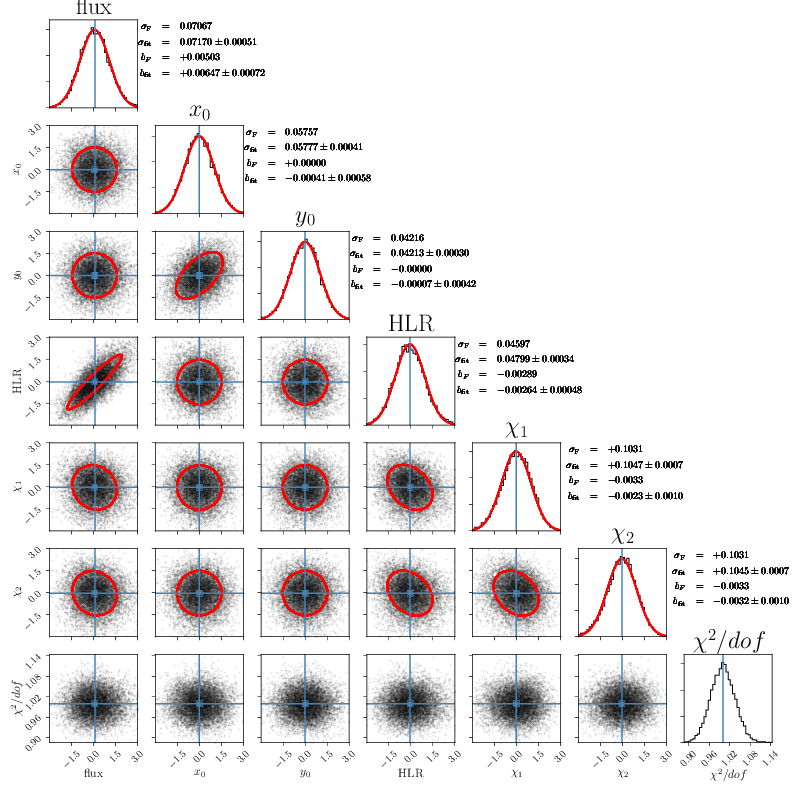

In [92]:
from wand.image import Image as WImage
img = WImage(filename=f'{project}/triangle_chi.pdf')
img